In [4]:

!pip install numpy
!pip install pandas
!pip install scikit-learn

!pip install torch


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [76]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score,precision_score,recall_score,confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


In [84]:
df = pd.read_csv("merged_train.csv")
del df["smpl"]
df

,target,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,0,0,0.468142,-1.045346,0.0,0.384487,0.435121,-1.178548,0.124543,1.801544,...,-0.361507,-1.026853,0.0,1.418600,-0.929668,1.284014,0.731842,0.801786,-0.728297,-0.412095
1,0,1,-0.760983,0.515132,0.0,-1.673905,-0.393862,-1.584207,-0.439778,0.796104,...,-0.546275,-1.489542,0.0,-0.622007,-0.473156,0.780020,0.648577,0.646100,-0.789362,0.083349
2,0,2,1.658855,0.915052,0.0,-0.581082,0.477199,-0.622226,0.390642,0.753299,...,-0.485999,0.586012,0.0,0.361481,-0.364566,-1.318596,-0.385155,0.140133,0.123245,-0.670030
3,0,3,-0.638854,0.314099,0.0,0.000919,1.102342,-0.807371,0.329158,0.484305,...,0.321985,-0.075827,0.0,-1.629672,0.876864,0.411271,0.433440,0.997364,2.829590,-1.275588
4,0,4,-1.091376,0.859811,0.0,-0.505439,1.665086,-0.912464,-0.332054,0.707705,...,0.828886,0.140387,0.0,-0.624304,-2.197691,-1.479267,-0.465917,-0.014757,-0.320434,-0.511896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20614,0,16740,1.054036,0.781726,0.0,0.354015,0.031608,0.505571,-0.391351,-0.362796,...,-0.546639,-1.083213,0.0,-0.141812,1.298495,0.485861,-0.284795,0.445140,-1.649364,0.901836
20615,0,16741,-0.181712,-1.703955,0.0,0.125573,-1.236718,0.360849,-0.527227,-0.812237,...,0.865396,0.073210,0.0,-0.802118,-2.277912,-0.227848,-0.020259,-1.445771,1.290703,-0.015311
20616,0,16742,-0.322872,-0.339665,0.0,-0.725504,-0.260038,0.651661,-0.116402,-0.154363,...,0.601178,0.298002,0.0,1.332212,0.994915,0.389641,0.073859,-1.399902,-0.097716,-1.579794
20617,0,16743,-0.044867,1.307402,0.0,0.494602,-0.573069,0.401516,0.386289,0.155312,...,1.135809,-0.869840,0.0,-1.099552,0.981087,0.457334,0.882776,-1.473003,1.360535,-0.680987


In [78]:
X = df.drop(["target"],axis=1)
y = df["target"]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
# Объединяем X и y для обучающего и тестового наборов
train_data = X_train.copy()
train_data['label'] = y_train
train_data['id'] = X_train['id']

test_data = X_test.copy()
test_data['label'] = y_test
test_data['id'] = X_test['id']
# Функция для создания последовательностей
def create_sequences(data):
    sequences = []
    labels = []
    ids = data['id'].unique()
    for id_ in ids:
        group = data[data['id'] == id_]
        seq_features = group.drop(['label', 'id'], axis=1).values
        seq_label = group['label'].values[-1]  # Предположим, что метка — последняя в последовательности
        sequences.append(seq_features)
        labels.append(seq_label)
    return sequences, labels

# Создаем последовательности для обучения и тестирования
X_train_seq, y_train_seq = create_sequences(train_data)
X_test_seq, y_test_seq = create_sequences(test_data)


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
X_pca = pca.fit_transform(X_scaled)


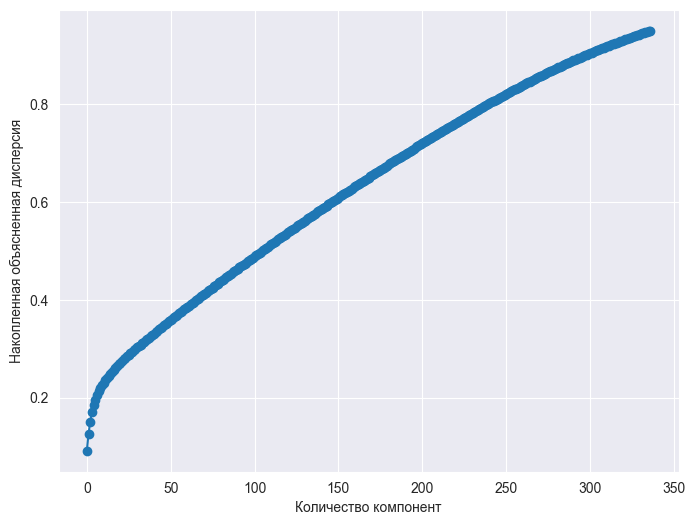

In [82]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объясненная дисперсия')
plt.grid(True)
plt.show()


In [83]:
components = pd.DataFrame(pca.components_, columns=X.columns)
display(components)


,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,0.012667,0.006476,0.005283,-0.110996,0.109232,0.043099,0.086832,0.084686,0.004070,0.009610,...,0.007505,0.001564,-0.014867,-0.002319,0.014614,0.126005,0.117004,0.043388,0.000369,0.007698
1,0.143411,0.003812,0.006763,0.092776,-0.037888,-0.039911,0.133609,-0.092462,-0.056059,0.015424,...,0.008155,-0.001404,0.021682,0.001675,0.026661,-0.050341,-0.051373,-0.021668,0.000620,-0.000568
2,-0.071995,-0.023934,0.000703,0.115675,0.072783,-0.048022,-0.038713,-0.125888,0.006077,-0.006916,...,-0.016931,-0.000662,0.122816,0.001497,-0.008769,0.062708,0.079164,0.025406,0.001945,-0.008388
3,0.034301,0.016065,-0.000669,-0.087006,-0.033124,0.037362,0.018790,0.116706,-0.000794,0.003280,...,0.010813,0.000062,0.188160,-0.000970,0.006403,-0.022682,-0.037718,-0.009946,0.002256,0.005233
4,0.154789,-0.002881,0.019900,-0.001088,-0.006894,0.003144,-0.017701,-0.014938,-0.019262,0.020234,...,0.007910,0.002625,0.005165,0.000620,0.056073,-0.003948,0.013154,0.007665,-0.000898,0.014200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,-0.010412,-0.005892,0.006466,-0.041117,0.058096,-0.014977,-0.017864,0.049927,-0.000792,-0.007290,...,-0.028538,-0.000261,0.153388,0.002283,0.002829,-0.002005,0.012148,0.015417,0.009280,-0.007403
333,0.022149,0.003794,-0.001803,0.028692,-0.014652,0.025900,0.051042,-0.017959,0.003700,0.000881,...,0.014928,0.015503,0.041421,-0.010954,0.014814,0.007834,0.069368,-0.012776,-0.005399,0.012128
334,0.017408,0.006947,-0.023253,0.037552,0.023956,0.013277,-0.017212,-0.045593,-0.001261,-0.009279,...,0.009716,0.002960,-0.070092,-0.016140,-0.009435,-0.007155,0.115719,0.050600,-0.007503,0.000820
335,0.026855,-0.000054,0.012535,0.017034,-0.104502,-0.011821,0.021558,0.043395,0.003667,0.013806,...,0.005560,0.001555,0.102758,-0.010485,-0.014218,-0.031690,0.136519,0.006921,0.008335,0.004775


In [65]:
import torch
from torch.utils.data import Dataset, DataLoader

# Устанавливаем устройство (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')


Используется устройство: cpu


In [66]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        # Преобразуем в тензоры
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        return sequence, label


In [67]:
# Создаем экземпляры Dataset
train_dataset = SequenceDataset(X_train_seq, y_train_seq)
test_dataset = SequenceDataset(X_test_seq, y_test_seq)

# Создаем DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)


In [68]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.float32)

    # Сортируем последовательности по длине (требуется для pack_padded_sequence)
    lengths = torch.tensor([len(seq) for seq in sequences])
    lengths, perm_idx = lengths.sort(0, descending=True)
    sequences = [sequences[i] for i in perm_idx]
    labels = labels[perm_idx]

    # Паддируем последовательности
    sequences_padded = pad_sequence(sequences, batch_first=True)

    return sequences_padded, lengths, labels
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


In [69]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Слой LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        # Полносвязный слой
        self.fc = nn.Linear(hidden_size, 1)
        # Сигмоидная функция активации
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        # Пакуем последовательности
        packed_input = pack_padded_sequence(x, lengths, batch_first=True)
        # Передаем через LSTM
        packed_output, (h_n, c_n) = self.lstm(packed_input)
        # Используем последний скрытый слой
        h_n = h_n[-1]  # shape: (batch_size, hidden_size)
        # Проходим через полносвязный слой и сигмоид
        out = self.fc(h_n)
        out = self.sigmoid(out)
        return out


In [70]:
# Определяем размеры
input_size = X_train_seq[0].shape[1]  # Количество признаков
hidden_size = 64
num_layers = 2

# Инициализируем модель
model = RNNModel(input_size, hidden_size, num_layers)
model.to(device)


RNNModel(
  (lstm): LSTM(418, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [71]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30
loss_fn = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for sequences_padded, lengths, labels in train_loader:
        sequences_padded = sequences_padded.to(device)
        labels = labels.to(device).unsqueeze(1)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(sequences_padded, lengths)

        # Вычисляем потерю
        loss = criterion(outputs, labels)

        #cross_loss = loss_fn(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        #cross_loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/30], Loss: 0.3152
Epoch [2/30], Loss: 0.0960
Epoch [3/30], Loss: 0.0919
Epoch [4/30], Loss: 0.0892
Epoch [5/30], Loss: 0.0864
Epoch [6/30], Loss: 0.0832
Epoch [7/30], Loss: 0.0795
Epoch [8/30], Loss: 0.0756
Epoch [9/30], Loss: 0.0705
Epoch [10/30], Loss: 0.0650
Epoch [11/30], Loss: 0.0590
Epoch [12/30], Loss: 0.0521
Epoch [13/30], Loss: 0.0452
Epoch [14/30], Loss: 0.0378
Epoch [15/30], Loss: 0.0305
Epoch [16/30], Loss: 0.0237
Epoch [17/30], Loss: 0.0178
Epoch [18/30], Loss: 0.0128
Epoch [19/30], Loss: 0.0089
Epoch [20/30], Loss: 0.0061
Epoch [21/30], Loss: 0.0041
Epoch [22/30], Loss: 0.0026
Epoch [23/30], Loss: 0.0016
Epoch [24/30], Loss: 0.0010
Epoch [25/30], Loss: 0.0007
Epoch [26/30], Loss: 0.0005
Epoch [27/30], Loss: 0.0003
Epoch [28/30], Loss: 0.0002
Epoch [29/30], Loss: 0.0002
Epoch [30/30], Loss: 0.0001


In [74]:
model.eval()
y_true = []
y_pred = []
y_pred_proba = []

with torch.no_grad():
    for sequences_padded, lengths, labels in test_loader:
        sequences_padded = sequences_padded.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(sequences_padded, lengths)

        y_true.extend(labels.cpu().numpy())
        y_pred_proba.extend(outputs.cpu().numpy())
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.cpu().numpy())



In [75]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
y_pred_proba = np.array(y_pred_proba).flatten()

recall_rnn = recall_score(y_true, y_pred)
precision_rnn = precision_score(y_true, y_pred)
roc_auc_rnn = roc_auc_score(y_true, y_pred_proba)
conf_matrix_rnn = confusion_matrix(y_true, y_pred)

print(f"Recall: {recall_rnn}")
print(f"Precision: {precision_rnn}")
print(f"ROC-AUC: {roc_auc_rnn}")
print(f"Confusion Matrix:\n{conf_matrix_rnn}")


Recall: 0.011904761904761904
Precision: 0.1
ROC-AUC: 0.620170320603489
Confusion Matrix:
[[4031    9]
 [  83    1]]


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Предположим, что X_train_seq, y_train_seq, X_test_seq, y_test_seq уже созданы

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = [scaler.fit_transform(seq) for seq in X_train_seq]
X_test_scaled = [scaler.transform(seq) for seq in X_test_seq]

# Определение Dataset и DataLoader
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        sequence = torch.tensor(sequence, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        return sequence, label

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    sequences_padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.float32)
    lengths, perm_idx = lengths.sort(0, descending=True)
    sequences_padded = sequences_padded[perm_idx]
    labels = labels[perm_idx]
    return sequences_padded, lengths, labels

train_dataset = SequenceDataset(X_train_scaled, y_train_seq)
test_dataset = SequenceDataset(X_test_scaled, y_test_seq)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Определение Модели с Bidirectional LSTM и Dropout
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=True, dropout=0.5):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=bidirectional, dropout=dropout)
        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction_factor, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True)
        packed_output, (h_n, c_n) = self.lstm(packed_input)
        if self.bidirectional:
            # Конкатенация скрытых состояний из обоих направлений
            h_n = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_n = h_n[-1]
        out = self.fc(h_n)
        out = self.sigmoid(out)
        return out

# Инициализация Модели
input_size = X_train_scaled[0].shape[1]
hidden_size = 64
num_layers = 2

model = RNNModel(input_size, hidden_size, num_layers).to(device)

# Взвешенные Потери
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.BCELoss(weight=class_weights[y_train_seq].to(device))  # Убедитесь, что веса корректны

# Оптимизатор с L2 Регуляризацией
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Обучение Модели
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for sequences_padded, lengths, labels in train_loader:
        sequences_padded = sequences_padded.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(sequences_padded, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Оценка Модели
model.eval()
y_true = []
y_pred = []
y_pred_proba = []

with torch.no_grad():
    for sequences_padded, lengths, labels in test_loader:
        sequences_padded = sequences_padded.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(sequences_padded, lengths)

        y_true.extend(labels.cpu().numpy())
        y_pred_proba.extend(outputs.cpu().numpy())
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
y_pred_proba = np.array(y_pred_proba).flatten()

recall_rnn = recall_score(y_true, y_pred)
precision_rnn = precision_score(y_true, y_pred)
roc_auc_rnn = roc_auc_score(y_true, y_pred_proba)
conf_matrix_rnn = confusion_matrix(y_true, y_pred)

print(f"Recall: {recall_rnn}")
print(f"Precision: {precision_rnn}")
print(f"ROC-AUC: {roc_auc_rnn}")
print(f"Confusion Matrix:\n{conf_matrix_rnn}")


In [ ]:
from collections import Counter
print("Train class distribution:", Counter(y_train_seq))
print("Test class distribution:", Counter(y_test_seq))
